<a href="https://colab.research.google.com/github/AlviPat9/AppliedDSCapstone/blob/main/PEC1_Alvaro_Marcos_Canedo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam

import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Check for GPU
!nvidia-smi

print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mon Apr 22 19:25:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# PEC1 - Generative Adversarial Networks
A partir del conjunto de datos CIFAR10, se debe entrenar una *DCGAN* (*Deep Convolutional Generative Adversarial Network*) para generar nuevas imágenes. Una vez implementada la red, se deberá agregar *experience replay* y comparar los resultados con los obtenidos en la red inicial. Por último, se deberá convertir la red en una GAN condicional.

## Instrucciones
Se debe contestar a cada apartado de la práctica en el espacio correspondiente de esta plantilla. Los apartados que se deben contestar en lenguaje natural (utilizando las celdas de tipo Markdown), se han resaltado en amarillo. Se debe añadir debajo del texto resaltado la respuesta correspondiente. Cuando el texto subrayado indique algún requisito de la respuesta (por ejemplo en cuanto a longitud de la respuesta), será imprescindible ajustarse a dicho requisito. Los apartados que requieren código en Python deberán contestarse en los espacios de código previstos para ello. Al igual que las respuestas en celdas de tipo markdown, las respuestas de código pueden tener asociados requisitos especiales. Estos espacios se delimitan con la siguiente estructura:
``` python
# INICIO_RESPUESTA
# Requisitos: Elabore una función que siempre devuelva True

def mi_funcion() :
    return True

# FIN_RESPUESTA
```

## Esquema de la plantilla
El esquema de la memoria deberá ser el siguiente:

1. Explicar qué es una *DCGAN* y cómo funciona (haciendo énfasis en explicar las dos partes principales de este tipo de modelos)
1. Describir brevemente el conjunto de datos inicial (*CIFAR10*)
1. Entrenar una *DCGAN (Deep Convolutional Generative Adversarial Network)* para generar imágenes.
1. Añadir *experience replay*
1. Convertir la red a una *GAN condicional*

En primer lugar vamos a cargar las librerías y funciones de apoyo que se van a utilizar en el código del cuadernillo. Si se quiere utilizar alguna librería adicional se puede añadir dicha librería en este punto o en la celda de código en la que se vaya a utilizar por primera vez.


## Consideraciones iniciales

Dado el tiempo de cómputo que exigen este tipo de redes se limitará el análisis de 50 epochs. Es muy recomendable, también que, si no se dispone de una tarjeta gráfica y una configuración compatible con tensorflow (puede comprobarse con la última salida del bloque anterior, si el número de GPUs disponible es 0) se utilice para la realización de esta práctica Google Colab. En este plataforma deberemos configurar el entorno de ejecución para que soporte GPUs, esto puede hacerse a través del menú *Entorno de ejecución* y la opción *Cambiar tipo de entorno de ejecución*, selecconando **GPU** como *Acelerador por hardware* .

In [2]:
# Definimos las constantes que utilizaremos a lo largo del cuadernillo
batch_size = 128
epochs = 50
latent_dim = 100

Es importante saber que para poder depurar algunos métodos como «fit» debemos cambiar el modo de ejecución. Para ello podemos dar el valor «True» al parámetro «run_eagerly» cuando compilemos el modelo. Cuidado, al cambiar este parámetro la ejecución del código será mucho más lenta. Para más información y consejos de depuración se recomienda utilizar los consejos que se indican en la propia página de Keras (https://keras.io/examples/keras_recipes/debugging_tips/)

## Memoria
**Nombre:** <mark>Nombre</mark>

            Alvaro Marcos Canedo

**Correo UNED:** <mark>nombre@alumno.uned.es</mark>

            amarcos236@alumno.uned.es

### ¿Qué es una DCGAN?
<mark>\[Respuesta: Explicar lo que es una DCGAN, extensión aproximada de 2 párrafos (200 palabras) \]</mark>

DCGAN o *Deep Convolutional Generative Adversial Neural Networks*, se trata de una arquitectura de redes neuronales usadas en el ámbito del aprendizaje profundo donde se combinan los conceptos básicos de las *GAN* con el poder de procesamiento de imágenesde las *CNN* (*Convolutional Neural Networks*). Se entrenan dos redes neuronales que compiten entre si para generar nuevos datos, a partir de los datos de entrenamiento proporcionados. Una de las redes, el generador, intenta generar nuevos datos tomando una muestra de entrada, mientras que el discriminador trata de predecir si se trata de una imagen real (pertenciente a la base de datos) o falsa. Para el caso concreto de las DCGAN, la red generadora utiliza convoluciones traspuestas para aumentar la distribución de los datos, y el discriminador también usa capas convolucionales para clasificar los datos. Esta arquitectura hace que el modelo tenga una capacitación más estable.

La red generadora intenta maximizar la probabilidad de error del discriminante, mientras que este último intenta minimizar la probabilidad de error en su clasificación. Mediante el entrenamiento, ambas redes evolucionan y se confrontan de manera continua hasta alcanzar un equilibrio, donde el discriminador no llega a reconocer los datos sintéticos.


### CIFAR10
<mark>\[Respuesta: Describir brevemente el conjunto de datos CIFAR10, puede utilizar celdas de código para apoyarse en la descripción\]</mark>

In [3]:
# En primer lugar vamos a descargar el conjunto de datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# INICIO_RESPUESTA 0/7
# Requisitos: De como valor de la variable «semilla_aleatoria» los últimos dos dígitos de su documento de identificación
# DNI: 70910259 - V
semilla_aleatoria = 59
# FIN_RESPUESTA

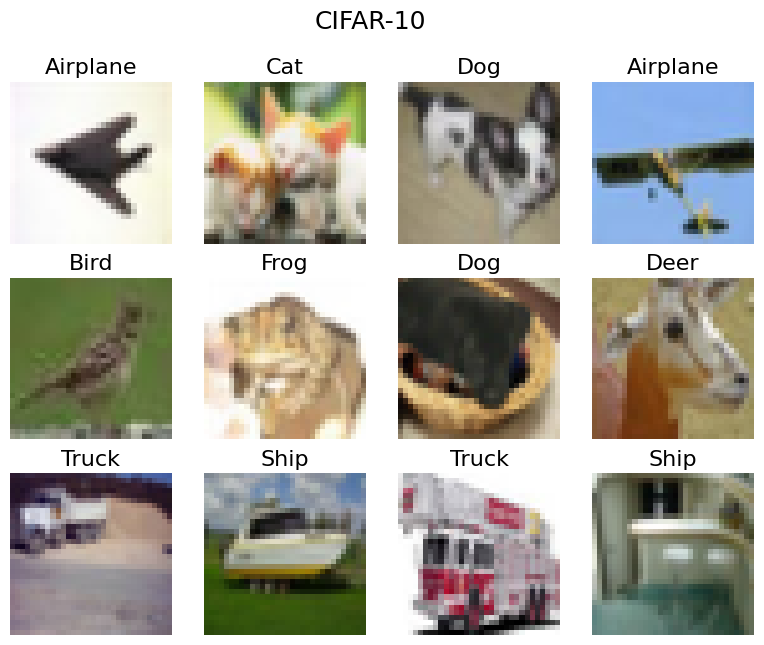

In [5]:
np.random.seed(semilla_aleatoria)
tf.random.set_seed(semilla_aleatoria)

# Vamos a visualizar un subconjunto de las imagenes que hemos cargado
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

### Pre-procesado de datos
<mark>\[Respuesta: Describir los pasos de preprocesado que se han realizado así como la justificación de los mismos (tener en cuenta que se utilizará la función de activación tangencial hipèrbólica)\]</mark>


Para el preprocesado de los datos lo que se ha hecho ha sido cambiar el rango de valores presente en todas las imágenes de la base de datos, de manera que cambie del rango \[0, 255\], al rango \[-1, 1\], que merjorará el comportamiento del modelo que se propone.

In [6]:
# Dado que no tendremos una estructura de entrenamiento y validación, vamos a juntar todos las imágenes
all_imgs = np.concatenate([X_train, X_test])
all_labels = np.concatenate([Y_train, Y_test])

# INICIO_RESPUESTA 1/7
# Requisitos: Realice el pre-procesado de los datos de entrada teniendo en cuenta las recomendaciones que se indican en el capítulo 17 del libro, guarde el resultado en all_imgs.

all_imgs = (all_imgs - 127.5) / 127.5
all_imgs = all_imgs.astype(np.float32)
# FIN_RESPUESTA

In [7]:
print(all_imgs.min())
print(all_imgs.mean())
print(all_imgs.max())

-1.0
-0.052200183
1.0


### DCGAN Inicial
En este apartado se quiere crear una primera red usando la API secuencial de Keras.  Es importante en este punto revisar las recomendaciones que se presentan en el capítulo 17 del libro:

<mark>\[Respuesta: Describir las recomendaciones que se presentan en el capítulo 17 del libro. Si, tras la evaluación de estas recomendaciones se detectan inconsistencias o no se siguen todas, indicar por qué.\]</mark>

- Respecto a la arquitectura convolucional del generador, se recomienda usar capas de convolución transpuestas para aumentar progresivamente la resolución espacial de la imagen, mientras que para el discriminador se recomienda usar capas convolucionales normales.

- Para ambas arquitecturas, se recomienda usar capas de *batch normalization*, ya que ayudan a acelerar el rendimiento y estabilizar el aprendizaje.

- Para el generador se recomienda usar la función de activación *ReLU* para todas las capas excepto la de salida, donde se quiere usar la función tangente hiperbólica, ya que garantiza que las salidas están en el rango del \[-1, 1\], como los datos de entrenamiento.

- Para el discriminador, se busca usar la función *LeakyReLU* en todas las capas convolucionales, que ayuda a prevenir el problema de las neuronas muertas y permite que los gradientes fluyan incluso cuando la activación es negativa.

- Se recomienda usar la función de pérdida de entropía cruzada binaria *Binary cross entropy*. Implica minimizar la pérdida del discriminador cuando clasifica correctamente las imágenes (tanto reales como falsas), y mazimizarla cuando el generador engaña al discriminador.

- Uso del optimizador Adam, con una tasa de aprendizaje baja para entrenar ambas arquitecturas. Establecer un *learning rate* bajo ayuda a estabilizar el entrenamiento y evitar oscilaciones drásticas en la calidad  de las imágenes generadas.

- Se recomienda también usar el entrenaimento por lotes (*batches*) en vez de la base de datos completa, que puede ayudar a acelerar el entrenamiento.

Los cambios del generador son:

 - EL uso de de *LeakyReLU* en todas las capas de convolución traspuestas. Puede ser para ayudar a prevenir problemas como el desvanecimiento del gradiente y el estancamiento del entrenamiento. Otras opciones puede ser que, al permitir valores negaticos, puede aumentar la capacidad representativa del generador, ayudando a capturar detalles finos y complejos, como texturas o bordes nítidos. También, hay que tener en cuenta que los datos proporcionados están definidos en el rango de \[-1, 1\].


Para el discriminador:
 - En el discriminador se añade, después de cada capa de *batch normalization*, una capa *Dropout*, que introduce ruido en el proceso de entrenamiento desactivando aleatoriamente un porcentaje definido de unidades de la red, por iteración. Esto ayuda a prevenir el sobreajuste (*overfitting*) y hace que el proceso de generación sea más robusto. Otra de las características a las que ayuda esta capa es a prevenir el colapso del entrenamiento, donde el discriminador se enfoca en un subconjunto limitado de características de los datos. el *dropout* ayuda a mitigar este problema añadiendo cierta variabilidad del modelo.

#### Generador

Para el generador se utilizará la siguiente estructura:

1. Capa densa y reshape a 8 x 8 x 128
2. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa de convolución transpuesta con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa convolucional con 3 filtros (kernel de 3x3, 1 stride, padding 'same' y función de activación 'tanh')

Todas las capas convolucionales transpuestas tienen una función de activación Leaky ReLU (únicamente las transpuestas) y, tras cada capa se aplicará normalización por lotes (BatchNormalization).

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Input(shape=(100,)),

# INICIO_RESPUESTA 2/
# Requisitos: Añada las capas indicadas para el generador
    keras.layers.Dense(8 * 8 * 128),
    keras.layers.Reshape([8, 8, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh")
# FIN_RESPUESTA
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 8, 8, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 64)        131136    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 64)        256       
 chNormalization)                                                
                                                        

#### Discriminador

Para el Discriminador se utilizará la siguiente estructura:

1. Capa convolucional con 32 filtros (kernel de 4x4, 2 strides y padding 'same')
2. Capa convolucional con 64 filtros (kernel de 4x4, 2 strides y padding 'same')
3. Capa convolucioanl con 128 filtros (kernel de 4x4, 2 strides y padding 'same')
4. Capa Densa con función de activación sigmoide

Todas las capas convolucionales tienen una función de activación Leaky ReLU y, posteriormente se aplicarán normalización (BatchNormalization) y Dropout. Salvo la última capa convolucional que no aplicará normalización si no que aplanará el resultado de cara a la última capa densa.

In [ ]:
discriminator = keras.models.Sequential([
# INICIO_RESPUESTA 3/7
# Requisitos: Añada las capas indicadas para el discriminador
    keras.layers.Conv2D(32, kernel_size=4, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
# FIN_RESPUESTA
])

discriminator

#### Modelo
<mark>\[Respuesta: Explicar los pasos de entrenamiento de una GAN, diferenciando el proceso de entrenamiento del generador y del discriminador. \]</mark>

El entrnamiento de una GAN se divide en dos fases:

 - Inicialmente, se entrena el discriminador. Se coge un conjunto de imágenes reales de la base de datos y se completa el *batch* con un número de imágenes falsas producidas por el generador. Se añade el *label* o clase 0 a las imágenes falsas generadas por el discriminador, mientras que se añade un 1 para las imágenes reales. Medianta este *batch*, se entrena un único paso del discriminador usando la función de pérdida *binary-cross entropy*.

 - En la segunda gase, se entrena el generador. Se produce otro *batch* de imágenes falsas y se usa el discriminador para la clasificación de las imágenes. En esta fase no se cogen imágenes de la base de datos, y todas las imágenes creadas se etiquetan con un 1. Por tanto, ahora se busca que el generador produzca unas imágenes que el discriminador asumirá como reales. Esta parte del entrenamiento está centrada en el generador. Los pesos del discriminador están *congelados* en este paso del entrenamiento, por tanto, la *backpropagation* sólo afecta a los pesos del generador.


In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100, show_range=10, enable_show=True, enable_save=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          generated_images = self.model.generator(random_latent_vectors)
          generated_images += 1
          generated_images /= 2

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [8]:
def plt_loss(history):
    '''
    Función que nos ayudará a visualizar la evolución de las pérdidas del generador y del discriminador
    '''
    f_num = "{:.3f}"
    plt.figure(figsize=(12,5))
    plt.suptitle("Función de pérdida", size=18)
    plt.subplots_adjust(wspace=0.5, hspace = 0.5)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'])
    plt.title("Discriminador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'])
    plt.title("Generador")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.tight_layout(pad=4)
    plt.show()
    print(f"Pérdida discriminador: Min ({f_num.format(np.min(history.history['d_loss']))}) Max ({f_num.format(np.max(history.history['d_loss']))}) Media ({f_num.format(np.mean(history.history['d_loss']))})")
    print(f"Pérdida generador: Min ({f_num.format(np.min(history.history['g_loss']))}) Max ({f_num.format(np.max(history.history['g_loss']))}) Media ({f_num.format(np.mean(history.history['g_loss']))})")

#### Optimizadores y función de pérdida
<mark>\[Respuesta: Explicar qué optimizadores se utilizarán para el discriminador y el generador y por qué. \]</mark>

Para mejorar los resultados tradicionales de las GAN, lo mejor es usar optimizadores del tipo *adaptative gradients*. Estos optimizadores normalizan los gradientes basándose en la desviación estándar, de modo que todos los parámetros tienen el mismo rango dinámico. Parámetros con un rango dinámico muy amplio tienen tiempos de entrenamiento mayores, tendiendo a la inestabilidad. Reescalando los pesos de cada parámetro de la red neuronal de manera intrínseca al model en vez de hacer el reescalado en la inicialización permite tener este rango dinámico durante el entrenamiento, llegando a una velocidad de aprendizaje similiar para todos los parámetros. Esta característica hace que se aumente la velocidad y estabilidad del entrenamiento.

In [9]:
# INICIO_RESPUESTA 4/7
# Requisitos: Inicialice los optimizadores que se utilizarán para el discriminador y para el generador, se aconseja utilizar valores LR de aproximadamente 0.0002
d_optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
g_optimizer = keras.optimizers.RMSprop(learning_rate=0.0001)
# FIN_RESPUESTA

loss_fn = keras.losses.BinaryCrossentropy()

Epoch 1/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 0.5023 - g_loss: 1.6902

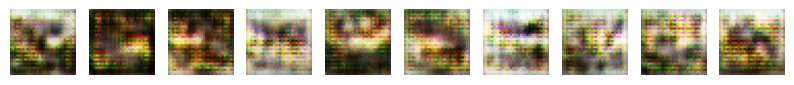

1875/1875 [==============================] - 24s 9ms/step - d_loss: 0.5026 - g_loss: 1.6891
Epoch 2/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6840 - g_loss: 0.7983
Epoch 3/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6913 - g_loss: 0.7696
Epoch 4/50
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6893 - g_loss: 0.7650
Epoch 5/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6816 - g_loss: 0.7750
Epoch 6/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6758 - g_loss: 0.7870
Epoch 7/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6789 - g_loss: 0.7862
Epoch 8/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6817 - g_loss: 0.7814
Epoch 9/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6827 - g_loss: 0.7800
Epoch 10/50
1872/1875 [============================>.] - ETA: 0s - d_loss: 0.6822 -

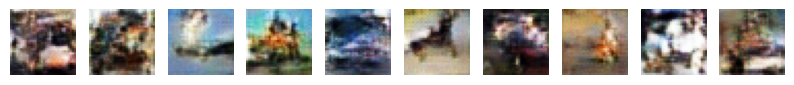

1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6822 - g_loss: 0.7793
Epoch 11/50
1875/1875 [==============================] - 25s 13ms/step - d_loss: 0.6812 - g_loss: 0.7819
Epoch 12/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6805 - g_loss: 0.7840
Epoch 13/50
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6796 - g_loss: 0.7850
Epoch 14/50
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6795 - g_loss: 0.7856
Epoch 15/50
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6790 - g_loss: 0.7867
Epoch 16/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6785 - g_loss: 0.7882
Epoch 17/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6776 - g_loss: 0.7911
Epoch 18/50
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6763 - g_loss: 0.7931
Epoch 19/50
1875/1875 [==============================] - 19s 10ms/step

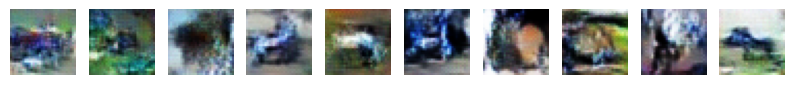

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6729 - g_loss: 0.7986
Epoch 21/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6732 - g_loss: 0.8006
Epoch 22/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6740 - g_loss: 0.8002
Epoch 23/50
1875/1875 [==============================] - 20s 11ms/step - d_loss: 0.6744 - g_loss: 0.7981
Epoch 24/50
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6748 - g_loss: 0.7972
Epoch 25/50
1875/1875 [==============================] - 19s 10ms/step - d_loss: 0.6746 - g_loss: 0.7986
Epoch 26/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6747 - g_loss: 0.7986
Epoch 27/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6748 - g_loss: 0.7978
Epoch 28/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6746 - g_loss: 0.7977
Epoch 29/50
1875/1875 [==============================] - 17s 9ms/step - 

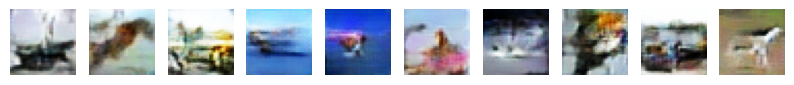

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6738 - g_loss: 0.7993
Epoch 31/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6738 - g_loss: 0.7997
Epoch 32/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6736 - g_loss: 0.8009
Epoch 33/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6725 - g_loss: 0.8018
Epoch 34/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6716 - g_loss: 0.8039
Epoch 35/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6707 - g_loss: 0.8048
Epoch 36/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6697 - g_loss: 0.8070
Epoch 37/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6686 - g_loss: 0.8090
Epoch 38/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6677 - g_loss: 0.8100
Epoch 39/50
1875/1875 [==============================] - 17s 9ms/step - d

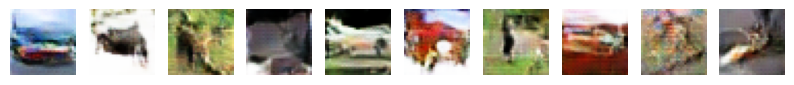

1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6656 - g_loss: 0.8178
Epoch 41/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6645 - g_loss: 0.8205
Epoch 42/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6632 - g_loss: 0.8226
Epoch 43/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6624 - g_loss: 0.8243
Epoch 44/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6608 - g_loss: 0.8278
Epoch 45/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6603 - g_loss: 0.8310
Epoch 46/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6586 - g_loss: 0.8332
Epoch 47/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6576 - g_loss: 0.8389
Epoch 48/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6564 - g_loss: 0.8403
Epoch 49/50
1875/1875 [==============================] - 18s 9ms/step - d_l

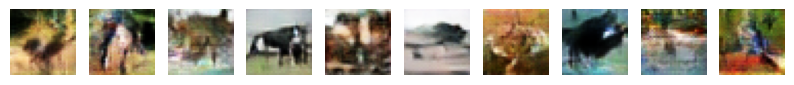

1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6543 - g_loss: 0.8470


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

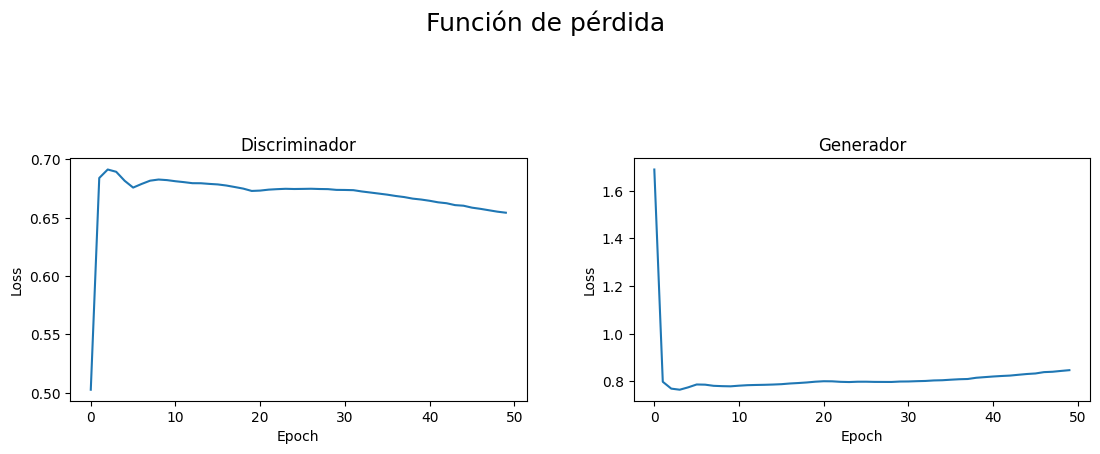

Pérdida discriminador: Min (0.503) Max (0.691) Media (0.669)
Pérdida generador: Min (0.765) Max (1.689) Media (0.820)


In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando la evolución de las pérdidas del discriminador y del generador. \]</mark>


El discriminador y el generador luchan en cada epoch para mejorar, respectivamente, sus funciones. El discriminador parece que tiene cierta tendencia a mejorar la discriminación entre las imágenes reales y las *fake*, mientras que el generador parece que le está costando más generar imágenes lo más realistas posibles.

En las imágenes intermedias que se pueden apreciar en el entrenamiento no se distinguen bien, pero uno de las posibles causas de esto puede ser que el modelo se haya quedado estancado en una pequeña parte de todas las características de las imágenes de la base de datos.


### Experience replay
<mark>\[Respuesta: Explicar en qué consiste la técnica de *Experience replay* y qué resultados se esperan de su uso. \]</mark>

El *experience replay* consiste en almacenar, de manera temporal, las imágenes producidas por el generador en cada iteración para evitar que el entrenamiento del modelo falle. Usando este método, el discriminador se entrena mediante las imágenes reales cogidas de la base de datos, y se completa con algunas de las imágenes almacenadas temporalmente en el *buffer* además de las nuevas imágenes falsas generadas. De esta manera se evita el *overfitting* que puede hacer que el entrenamiento falle. No se almacenan las imágenes durante todo el entrenamiento, sino que a medida que se itera sobre las *epochs* se van eliminando las imágenes más antiguas almacenadas.


<mark>\[Respuesta: Explicar qué estrategia de *Experience replay* (de las muchas posibles) se ha implementado en el modelo que hay a continuación. \]</mark>

Las imágenes generadas se almacenan en la lista experience_replay, y cuando esta lista alcanza un tamaño predefinido (replay_step), se ejecuta la experiencia de reproducción. Durante la reproducción, se calcula la pérdida del discriminador utilizando las imágenes almacenadas en experience_replay, y se actualizan los pesos del discriminador en función de esta pérdida. Esto ayuda a mejorar la estabilidad del entrenamiento, perimitiendo una generalización y aprendizaje del discriminador, ya que tiene una variedad de más amplia de imágenes generadas.

#### Modelo

In [ ]:
# Celda añadida para correr por separado los modelos
dataset = tf.data.Dataset.from_tensor_slices(all_imgs).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # INICIO_RESPUESTA 5/7
        # Requisitos: Implementar una estrategia de Experience replay a partir de un buffer de imágenes alamacenadas en cada iteración
        # Experience Replay
        generated_image = self.generator(tf.random.normal(shape=(batch_size, self.latent_dim)), training=False)
        self.experience_replay.append(generated_image)
        if len(self.experience_replay) == 20:
            replay_images = tf.concat(self.experience_replay, axis=0)
            self.experience_replay = []
            with tf.GradientTape() as tape:
                replay_predictions = self.discriminator(replay_images)
                replay_labels = tf.ones((len(replay_images), 1))
                replay_loss = self.loss_fn(replay_labels, replay_predictions)
                grads = tape.gradient(replay_loss, self.discriminator.trainable_weights)
                self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        # FIN_RESPUESTA

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

Epoch 1/50
1871/1875 [============================>.] - ETA: 0s - d_loss: 0.5434 - g_loss: 1.3948

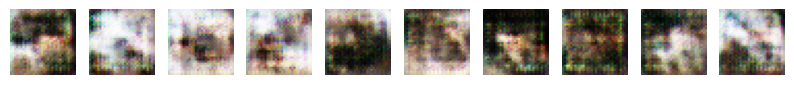

1875/1875 [==============================] - 23s 10ms/step - d_loss: 0.5437 - g_loss: 1.3936
Epoch 2/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6767 - g_loss: 0.8131
Epoch 3/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6887 - g_loss: 0.7724
Epoch 4/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6817 - g_loss: 0.7821
Epoch 5/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6763 - g_loss: 0.7913
Epoch 6/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6790 - g_loss: 0.7869
Epoch 7/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6831 - g_loss: 0.7777
Epoch 8/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6833 - g_loss: 0.7770
Epoch 9/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6840 - g_loss: 0.7745
Epoch 10/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6829 

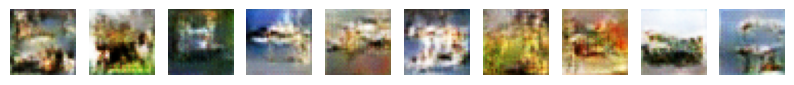

1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6830 - g_loss: 0.7754
Epoch 11/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6820 - g_loss: 0.7776
Epoch 12/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6814 - g_loss: 0.7808
Epoch 13/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6798 - g_loss: 0.7814
Epoch 14/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6800 - g_loss: 0.7835
Epoch 15/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6789 - g_loss: 0.7856
Epoch 16/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6786 - g_loss: 0.7865
Epoch 17/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6775 - g_loss: 0.7893
Epoch 18/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6762 - g_loss: 0.7921
Epoch 19/50
1875/1875 [==============================] - 17s 9ms/step - d_lo

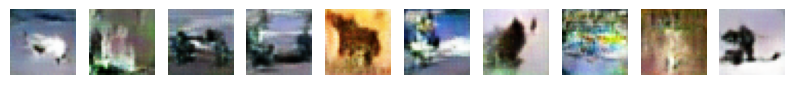

1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6751 - g_loss: 0.7955
Epoch 21/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6740 - g_loss: 0.7966
Epoch 22/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6733 - g_loss: 0.7992
Epoch 23/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6724 - g_loss: 0.8004
Epoch 24/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6720 - g_loss: 0.8022
Epoch 25/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6708 - g_loss: 0.8041
Epoch 26/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6699 - g_loss: 0.8082
Epoch 27/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6689 - g_loss: 0.8107
Epoch 28/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6672 - g_loss: 0.8135
Epoch 29/50
1875/1875 [==============================] - 17s 9ms/step - d_

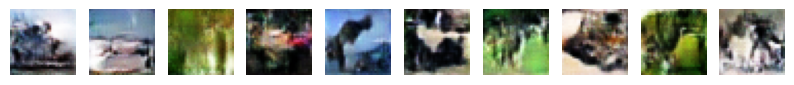

1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6640 - g_loss: 0.8218
Epoch 31/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6621 - g_loss: 0.8229
Epoch 32/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6610 - g_loss: 0.8273
Epoch 33/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6602 - g_loss: 0.8316
Epoch 34/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6593 - g_loss: 0.8314
Epoch 35/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6579 - g_loss: 0.8334
Epoch 36/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6579 - g_loss: 0.8374
Epoch 37/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6561 - g_loss: 0.8393
Epoch 38/50
1875/1875 [==============================] - 17s 9ms/step - d_loss: 0.6559 - g_loss: 0.8426
Epoch 39/50
1875/1875 [==============================] - 17s 9ms/step - d_l

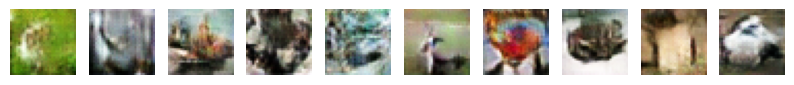

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6538 - g_loss: 0.8476
Epoch 41/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6520 - g_loss: 0.8511
Epoch 42/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6507 - g_loss: 0.8541
Epoch 43/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6486 - g_loss: 0.8568
Epoch 44/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6479 - g_loss: 0.8604
Epoch 45/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6468 - g_loss: 0.8656
Epoch 46/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6455 - g_loss: 0.8664
Epoch 47/50
1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6444 - g_loss: 0.8724
Epoch 48/50
1875/1875 [==============================] - 18s 9ms/step - d_loss: 0.6429 - g_loss: 0.8737
Epoch 49/50
1875/1875 [==============================] - 18s 10ms/step

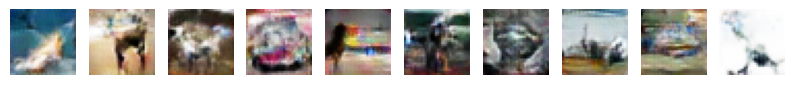

1875/1875 [==============================] - 18s 10ms/step - d_loss: 0.6397 - g_loss: 0.8815


In [ ]:
gan_er = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan_er.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn,
)

history = gan_er.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

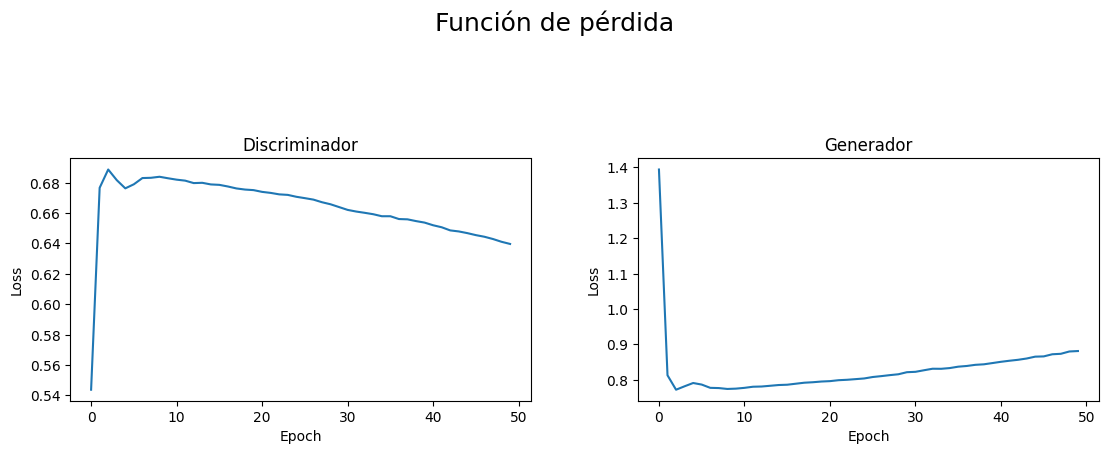

Pérdida discriminador: Min (0.544) Max (0.689) Media (0.664)
Pérdida generador: Min (0.772) Max (1.394) Media (0.828)


In [ ]:
plt_loss(history)

#### Resultados
<mark>\[Respuesta: Explicar los resultados obtenidos visualizando y compararlos con los obtenidos en la GAN sin *Experience replay*. \]</mark>

Para tratar de separa ambos casos, y que en el segundo modelo no se usen los pesos calculados en el primero, se han ejecutado todas las células previas, sin ejecutar el primer modelo de DCGAN.

Como se puede observar en ambas representaciones de la función de pérdida, la forma que tienen ambas funciones es semejante, aunque los resultados que se obtienen son ligeramente superiores en el modelo con experience replay.

Inicialmente, en las primeras epoch el modelo con *Experience Replay* tiene unos resultados peores que el modelo base, mientras que, según van avanzando las epochs, el *experience replay* se  va situando por encima, especialmente en el discriminador. La tendencia que tienen las funciones de pérdida son parecidas al modelo base, tendiendo el discriminador una pendiente aún más negativa, mientras que el generador, en este caso, tiene una función de pérdida con una pendiente positiva en las últimas epochs.

### GAN condicional
<mark>\[Respuesta: Explicar en qué consisten las GAN condicionales y qué resultados se esperan de estos modelos en relación al modelo original y al modelo con *Experience replay*. \]</mark>

Se trata de una variante de las GAN, en las que tanto el discriminador como el generador reciben información adicional (condiciones) además de una entrada
aleatoria de ruido. La introducción de esta información permite controlar y dirigir la generación de muestras.

Las cGAN destacan por su capacidad para generar muestras condicionadas, proporcionando un mayor control sobre el proceso de generación. Las DCGAN con y sin experience replay se centran en obtener una mayor estabilidad del entrenamiento y calidad de los resultados, mediante el uso de imágnes generadas previamente en el modelo con experience replay.

#### Discriminador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el discriminador para realizar la discriminación basado en la clase. \]</mark>

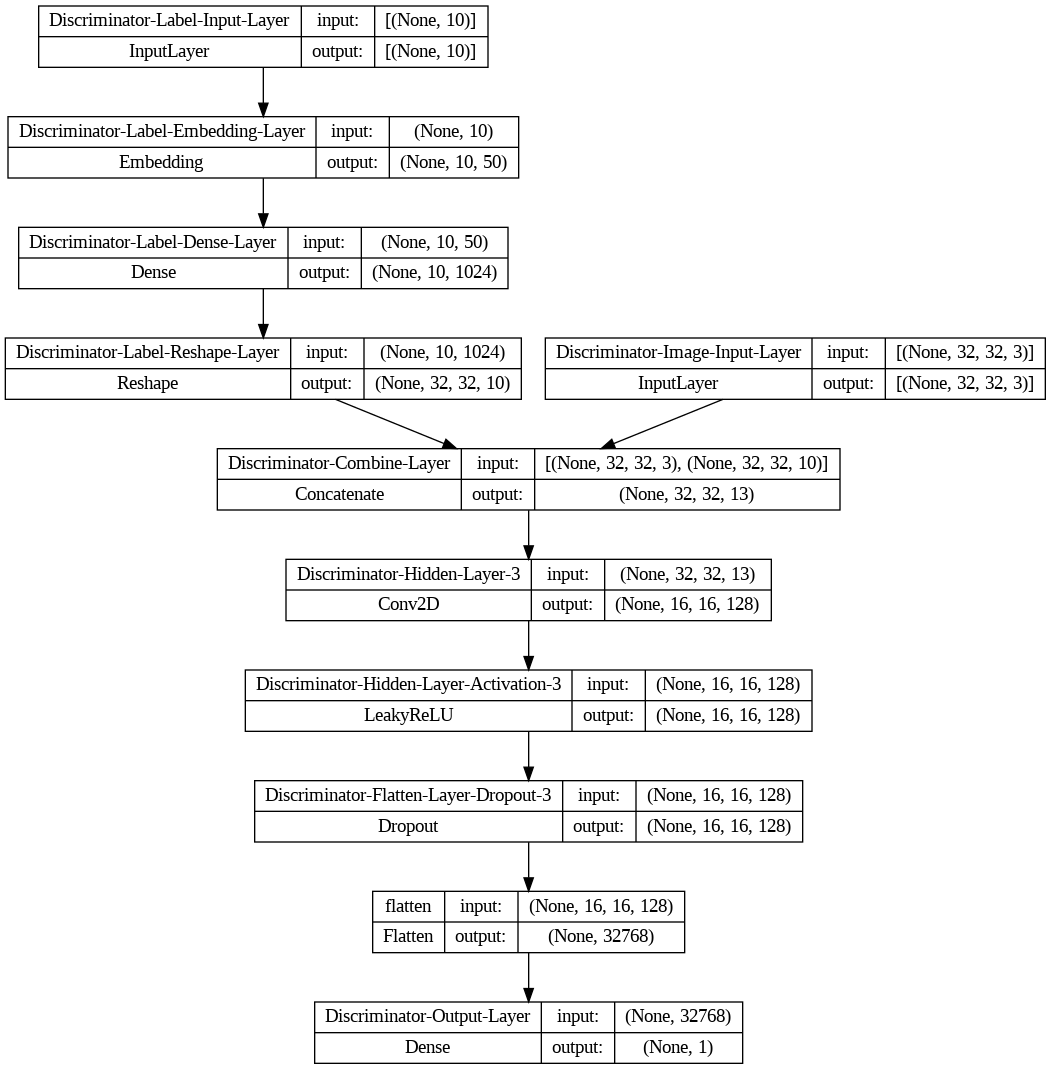

In [10]:
# INICIO_RESPUESTA 6/7
# Requisitos: Implemente el discriminador para la GAN condicional, utilice la estructura del discriminador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «discriminator» para almacenar el discriminador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

in_shape = (32, 32, 3,)

# Label Inputs
in_label = keras.layers.Input(shape=(10,), name='Discriminator-Label-Input-Layer') # Input Layer
lbls = keras.layers.Embedding(10, 50, name='Discriminator-Label-Embedding-Layer')(in_label) # Embed label to vector

# Scale up to image dimensions
n_nodes = in_shape[0] * in_shape[1]
lbls = keras.layers.Dense(n_nodes, name='Discriminator-Label-Dense-Layer')(lbls)
lbls = keras.layers.Reshape((in_shape[0], in_shape[1], 10), name='Discriminator-Label-Reshape-Layer')(lbls) # New shape

# Image Inputs
in_image = keras.layers.Input(shape=in_shape, name='Discriminator-Image-Input-Layer')

# Combine both inputs so it has two channels
concat = keras.layers.Concatenate(name='Discriminator-Combine-Layer')([in_image, lbls])

# Hidden Layer 1
h = keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-1')(concat)
h = keras.layers.LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-1')(h)
h = tf.keras.layers.BatchNormalization()(h)
h = keras.layers.Dropout(0.4, name='Discriminator-Flatten-Layer-Dropout-1')(h)

# Hidden Layer 2
h = keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-2')(concat)
h = keras.layers.LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-2')(h)
h = tf.keras.layers.BatchNormalization()(h)
h = keras.layers.Dropout(0.4, name='Discriminator-Flatten-Layer-Dropout-2')(h)

# Flatten and Output Layers
h = keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Discriminator-Hidden-Layer-3')(concat)
h = keras.layers.LeakyReLU(alpha=0.2, name='Discriminator-Hidden-Layer-Activation-3')(h)
h = keras.layers.Dropout(0.4, name='Discriminator-Flatten-Layer-Dropout-3')(h)
h = keras.layers.Flatten()(h)

output_layer = keras.layers.Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')(h) # Output Layer

# Define model
discriminator = keras.Model([in_image, in_label], output_layer, name='Discriminator')

tf.keras.utils.plot_model(discriminator, show_shapes=True)
# FIN_RESPUESTA

#### Generador
<mark>\[Respuesta: Explicar las adaptaciones que necesitará el generador para generar imágenes de una clase determinada. \]</mark>

Se necesita añadir la entrada de etiquetas al generador. Posteriormente se tienen que concatenar las entradas de riudo y etiquetas de las clases del modelo. Además, la primera capa se tiene que adaptar a la entrada del ruido y las etiquetas de las clases del modelo. El número de neuronas debe ser acorde al número necesario para procesar tanto el ruido como la información de las etiquetas.

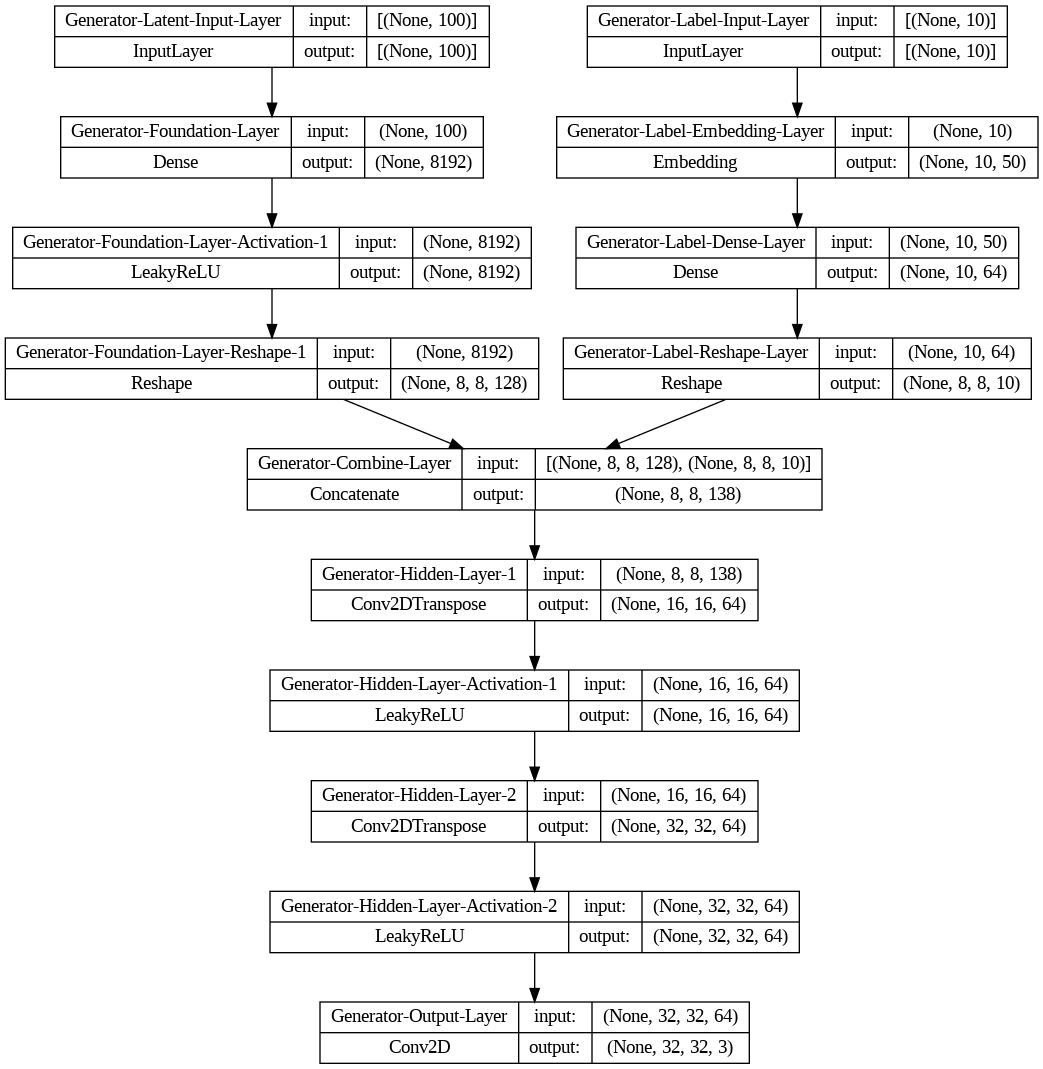

In [11]:
# INICIO_RESPUESTA 7/7
# Requisitos: Implemente el generador para la GAN condicional, utilice la estructura del generador original y adáptela para que funcione con las etiquetas de clase
#             (utilice la variable «generator» para almacenar el generador tal y como se hizo en el caso base)
# Nota: se recomienda utilizar la API funcional para desarrollar este apartado.

#
in_shape = (8, 8, 128)
# Label Inputs
in_label = keras.layers.Input(shape=(10,), name='Generator-Label-Input-Layer') # Input Layer
lbls = keras.layers.Embedding(10, 50, name='Generator-Label-Embedding-Layer')(in_label) # Embed label to vector

# Scale up to image dimensions
n_nodes = in_shape[0] * in_shape[1]
lbls = keras.layers.Dense(n_nodes, name='Generator-Label-Dense-Layer')(lbls)
lbls = keras.layers.Reshape((in_shape[0], in_shape[1], 10), name='Generator-Label-Reshape-Layer')(lbls) # New shape

# Generator Inputs (latent vector)
in_latent = keras.layers.Input(shape=(100,), name='Generator-Latent-Input-Layer')

# Image Foundation
n_nodes = 8 * 8 * 128 # number of nodes in the initial layer
g = keras.layers.Dense(n_nodes, name='Generator-Foundation-Layer')(in_latent)
g = keras.layers.LeakyReLU(alpha=0.2, name='Generator-Foundation-Layer-Activation-1')(g)
g = keras.layers.Reshape((in_shape[0], in_shape[1], 128), name='Generator-Foundation-Layer-Reshape-1')(g)

# Combine both inputs so it has two channels
concat = keras.layers.Concatenate(name='Generator-Combine-Layer')([g, lbls])

# Hidden Layer 1
g = keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-1')(concat)
g = keras.layers.LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-1')(g)

# Hidden Layer 2
g = keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-Hidden-Layer-2')(g)
g = keras.layers.LeakyReLU(alpha=0.2, name='Generator-Hidden-Layer-Activation-2')(g)

# Output Layer (Note, we use only one filter because we have a greysclae image. Color image would have three
output_layer = keras.layers.Conv2D(filters=3, kernel_size=(3, 3), activation='tanh', padding='same', name='Generator-Output-Layer')(g)

# Define model
generator = keras.Model([in_label,in_latent], output_layer, name='Generator')

tf.keras.utils.plot_model(generator, show_shapes=True)

# FIN_RESPUESTA 7/7

#### Modelo

In [12]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.experience_replay = []

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images[0])[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator([real_images[1],random_latent_vectors])

        combined_images = tf.concat([generated_images, real_images[0]], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        combined_labels = tf.concat([real_images[1], real_images[1]], axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_labels])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([real_images[1],random_latent_vectors]), real_images[1]])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))


        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, y_train_enc = None, num_img=3, latent_dim=100, show_range=10,
                 enable_show=True, enable_save=False,
                 batch_size = 128):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.show_range = show_range
        self.enable_show = enable_show
        self.enable_save = enable_save
        self.batch_size = batch_size
        self.y_train_enc = y_train_enc

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1) % self.show_range) == 0 or epoch == 0:
          random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
          labels = self.y_train_enc[epoch:epoch+self.num_img]
          generated_images = self.model.generator([labels,random_latent_vectors])
          generated_images = (generated_images + 1) / 2.0

          generated_images.numpy()
          plt.figure(figsize=(self.num_img, 1))
          for i in range(self.num_img):
              img = keras.preprocessing.image.array_to_img(generated_images[i])
              if self.enable_show:
                plt.subplot(1, self.num_img, i + 1)
                plt.imshow(img, cmap="binary")
                plt.axis("off")
              if self.enable_save:
                img.save("generated_img_%03d_%d.png" % (epoch, i))
          if self.enable_show:
            plt.show()

In [13]:
# Dado que ahora el generador y el discriminador utilizarán la clase de cada elemento, es necesario utilizar las etiquetas, transformándolas previamente a un array
all_labels_enc = keras.utils.to_categorical(all_labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((tf.cast(all_imgs, tf.float32), all_labels_enc)).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.3971 - g_loss: 1.6749

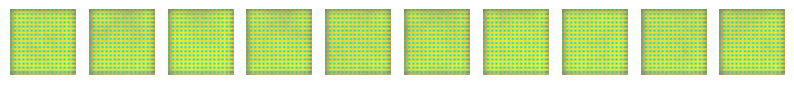

468/468 [==============================] - 20s 28ms/step - d_loss: 0.3997 - g_loss: 1.6736
Epoch 2/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.4985 - g_loss: 6.9698
Epoch 3/50
468/468 [==============================] - 13s 28ms/step - d_loss: 0.2096 - g_loss: 5.9329
Epoch 4/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.4412 - g_loss: 3.4802
Epoch 5/50
468/468 [==============================] - 14s 29ms/step - d_loss: 0.4754 - g_loss: 2.4519
Epoch 6/50
468/468 [==============================] - 13s 29ms/step - d_loss: 0.7308 - g_loss: 1.3417
Epoch 7/50
468/468 [==============================] - 13s 29ms/step - d_loss: 0.7338 - g_loss: 0.9465
Epoch 8/50
468/468 [==============================] - 14s 29ms/step - d_loss: 0.6619 - g_loss: 0.9667
Epoch 9/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6592 - g_loss: 0.9391
Epoch 10/50
467/468 [============================>.] - ETA: 0s - d_loss: 0.6499 - g_loss: 0.9

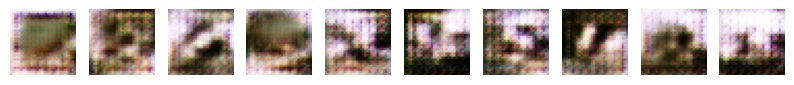

468/468 [==============================] - 14s 30ms/step - d_loss: 0.6499 - g_loss: 0.9345
Epoch 11/50
468/468 [==============================] - 14s 29ms/step - d_loss: 0.6493 - g_loss: 0.9245
Epoch 12/50
468/468 [==============================] - 14s 29ms/step - d_loss: 0.6487 - g_loss: 0.9047
Epoch 13/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6510 - g_loss: 0.8705
Epoch 14/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6678 - g_loss: 0.8523
Epoch 15/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6698 - g_loss: 0.8501
Epoch 16/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6701 - g_loss: 0.8354
Epoch 17/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6693 - g_loss: 0.8423
Epoch 18/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6817 - g_loss: 0.8176
Epoch 19/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6836

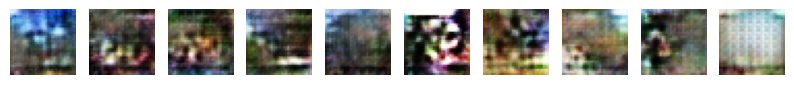

468/468 [==============================] - 14s 30ms/step - d_loss: 0.6861 - g_loss: 0.8052
Epoch 21/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6930 - g_loss: 0.7977
Epoch 22/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6941 - g_loss: 0.7876
Epoch 23/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6956 - g_loss: 0.7814
Epoch 24/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6992 - g_loss: 0.7764
Epoch 25/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.7007 - g_loss: 0.7736
Epoch 26/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.7033 - g_loss: 0.7677
Epoch 27/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.7057 - g_loss: 0.7631
Epoch 28/50
468/468 [==============================] - 17s 35ms/step - d_loss: 0.7039 - g_loss: 0.7632
Epoch 29/50
468/468 [==============================] - 15s 31ms/step - d_loss: 0.7002

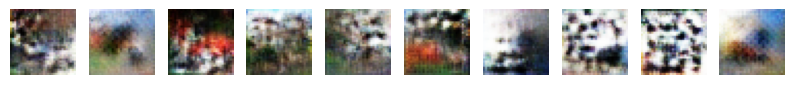

468/468 [==============================] - 14s 30ms/step - d_loss: 0.6977 - g_loss: 0.7668
Epoch 31/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6933 - g_loss: 0.7704
Epoch 32/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6898 - g_loss: 0.7760
Epoch 33/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6841 - g_loss: 0.7848
Epoch 34/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6752 - g_loss: 0.8021
Epoch 35/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6700 - g_loss: 0.8148
Epoch 36/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6727 - g_loss: 0.8101
Epoch 37/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6706 - g_loss: 0.8091
Epoch 38/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6778 - g_loss: 0.7948
Epoch 39/50
468/468 [==============================] - 14s 31ms/step - d_loss: 0.6791

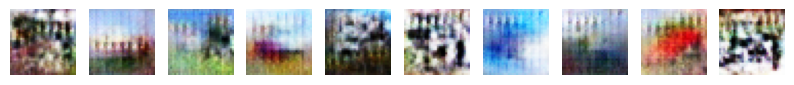

468/468 [==============================] - 14s 30ms/step - d_loss: 0.6837 - g_loss: 0.7910
Epoch 41/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6829 - g_loss: 0.7906
Epoch 42/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6816 - g_loss: 0.7873
Epoch 43/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6813 - g_loss: 0.7879
Epoch 44/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6843 - g_loss: 0.7875
Epoch 45/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6816 - g_loss: 0.7868
Epoch 46/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6870 - g_loss: 0.7867
Epoch 47/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6847 - g_loss: 0.7864
Epoch 48/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6829 - g_loss: 0.7843
Epoch 49/50
468/468 [==============================] - 14s 30ms/step - d_loss: 0.6848

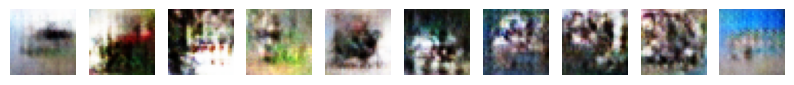

468/468 [==============================] - 14s 31ms/step - d_loss: 0.6859 - g_loss: 0.7834


In [14]:
conditional_gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
conditional_gan.compile(
    d_optimizer=d_optimizer,
    g_optimizer=g_optimizer,
    loss_fn=loss_fn
)

history = conditional_gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(all_labels_enc,
                                                                num_img=10,
                                                                latent_dim=latent_dim)])

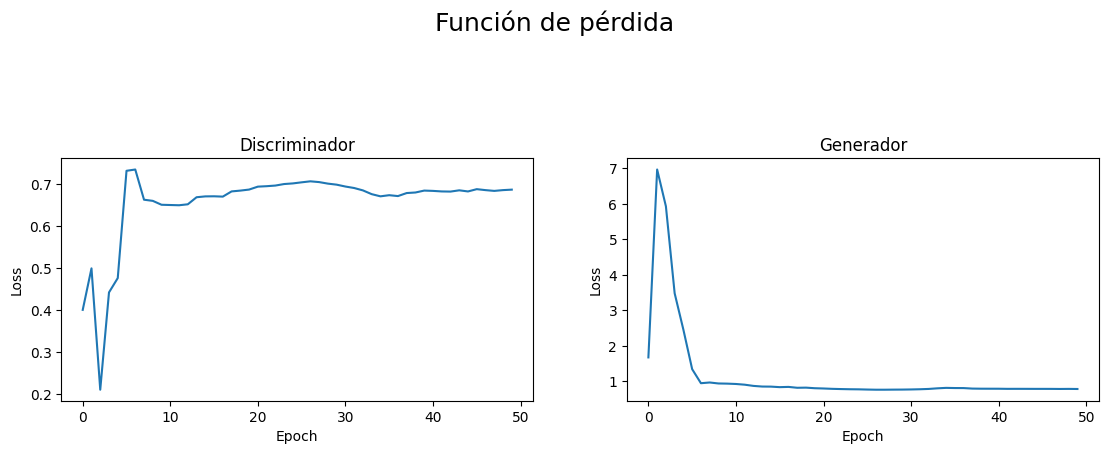

Pérdida discriminador: Min (0.210) Max (0.734) Media (0.655)
Pérdida generador: Min (0.763) Max (6.970) Media (1.154)


In [15]:
plt_loss(history)

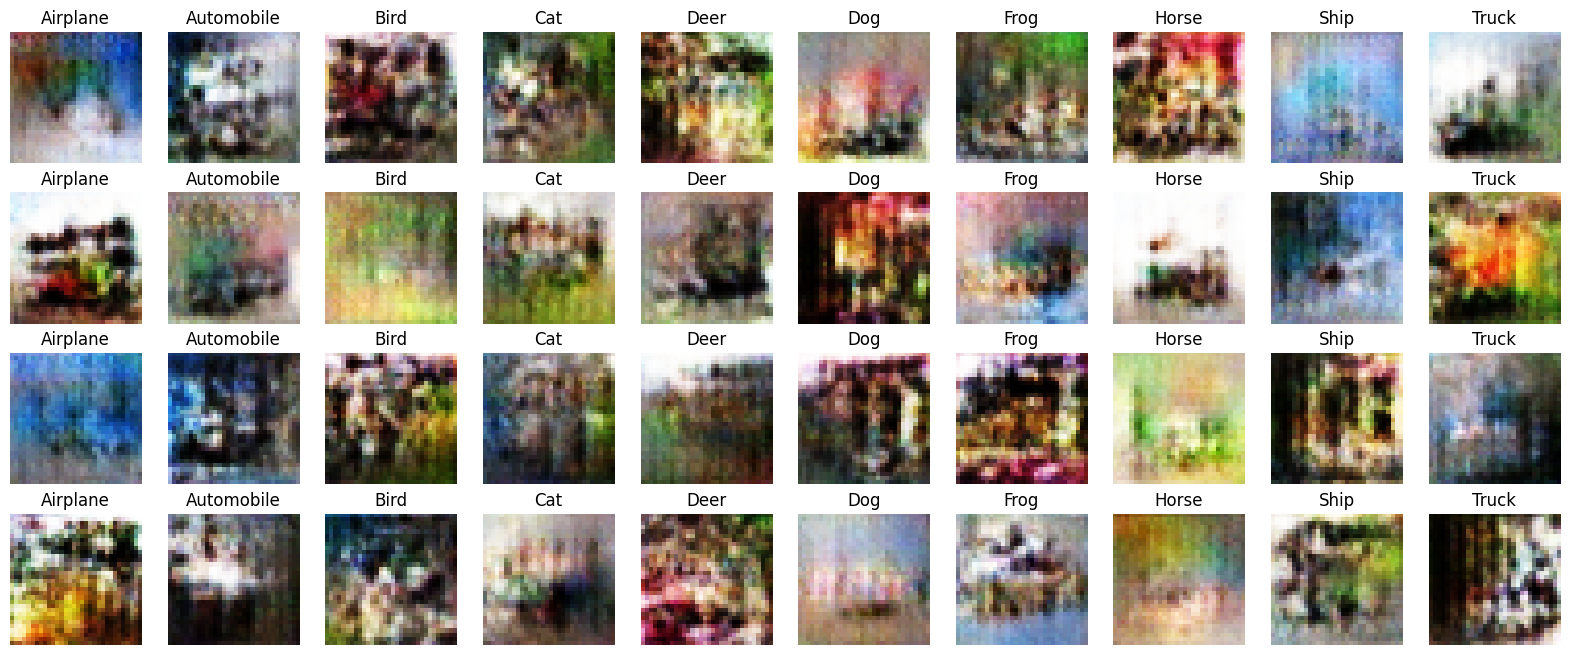

In [16]:
classes_labels = keras.utils.to_categorical([x for x in range(10)] * 4, 10)

random_latent_vectors = tf.random.normal(shape=(len(classes_labels), latent_dim))
generated_images = conditional_gan.generator([classes_labels,random_latent_vectors])
generated_images = (generated_images + 1) / 2.0
# generated_images.numpy()
plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
pos = 1
classes_to_int = np.argmax(classes_labels, axis=-1)
for n in range(generated_images.shape[0]):
    plt.subplot(4, 10, pos)
    img = keras.preprocessing.image.array_to_img(generated_images[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(clases[classes_to_int[n]], size=12)
    pos += 1
plt.show()

### Conclusiones finales
<mark>\[Respuesta: Resumir el trabajo realizado y las conclusiones principales que se extraen del mismo. \]</mark>

### (Opcional) Cycle-GANs
<mark>\[Respuesta: Buscar información de las *Cycle GANs* y resumir su funcionamiento, haciendo especial énfasis en las novedades que introducen sobre las tipologías vistas en esta práctica . \]</mark>